In [17]:
import time
import cv2
import numpy as np
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
from tsdf import TSDF, get_volume_bounds

## Data Processing

In [18]:
data_folder = "data/scene_table/"
cam_intrinsics_file = data_folder + "cam.txt"
frame_color_img_file = data_folder + "rgb_{:04d}.png"
frame_depth_img_file = data_folder + "depth_{:04d}.exr"
frame_pose_file = data_folder + "pose_{:04d}.txt"
frames_count = 500
cam_to_motion_T = np.diag([1, 1, 1, 1])
output_mesh_file = "textured_scene_outputs/scene_mesh.ply"
output_pc_file = "textured_scene_outputs/scene_pc.ply"

In [19]:
def process_data():
    frame_color_imgs = []
    frame_depth_imgs = []
    frame_poses = []

    # read the data
    for i in range(frames_count):
        color_img = cv2.imread(frame_color_img_file.format(i))
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
        # flip image horizontally
        color_img = cv2.flip(color_img, 1)
        frame_color_imgs.append(color_img)

        depth_img = cv2.imread(frame_depth_img_file.format(i), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
        depth_img = cv2.flip(depth_img, 1)
        depth_img[depth_img == 65504] = 0
        
        frame_depth_imgs.append(depth_img)
        frame_pose = np.loadtxt(frame_pose_file.format(i)) @ cam_to_motion_T
        frame_poses.append(frame_pose)
    return frame_color_imgs, frame_depth_imgs, frame_poses


In [20]:
frame_color_imgs, frame_depth_imgs, frame_poses = process_data()
cam_intrinsics = np.loadtxt(cam_intrinsics_file)

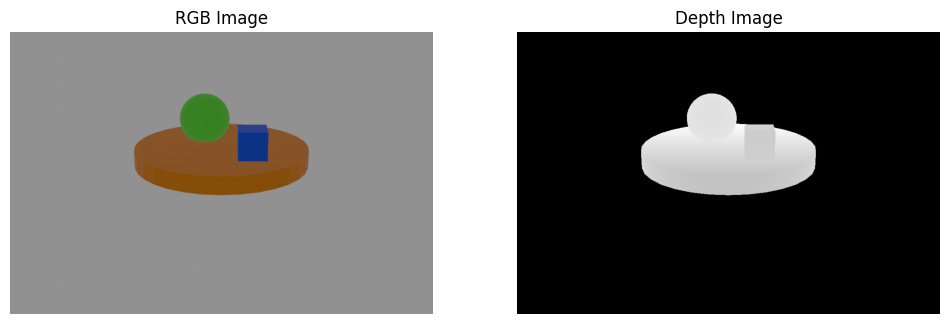

In [21]:
rgb_img = frame_color_imgs[0]
depth_img = frame_depth_imgs[0]
p = frame_poses[0]

import matplotlib.pyplot as plt
# plot the first frame
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("RGB Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(depth_img, cmap="gray")
plt.title("Depth Image")
plt.axis("off")
plt.show()

## TSDF Construction

In [22]:
tsdf_voxel_size = 0.015  # 2cm
tsdf_trunc_margin =5*tsdf_voxel_size  # 10cm

volume_bounds = get_volume_bounds(
    frames_count, frame_depth_imgs, frame_poses, cam_intrinsics
)

Volume bounds:
[[-2.1059835   2.10610509]
 [-1.93981886  1.93981886]
 [-2.10609388  2.10618114]]


In [23]:
tsdf_obj = TSDF(
    volume_bounds,
    voxel_size=tsdf_voxel_size,
    trunc_margin=tsdf_trunc_margin,
    run_on_gpu=True,
)
start_time = time.time()
tsdf_obj.build_tsdf(
    frames_count, frame_color_imgs, frame_depth_imgs, frame_poses, cam_intrinsics
)
end_time = time.time()
print("Time: ", end_time - start_time, "seconds")
print("FPS: ", frames_count / (end_time - start_time))

Volume dims:  [281 259 281]
Using GPU:  NVIDIA GeForce RTX 3090
Maximum number of threads per block: 1024
Maximum block dimension: 1024, 1024, 64
Maximum grid dimension: 2147483647, 65535, 65535
Block size: (1024, 1, 1), Grid size: (19972, 1, 1)
Fusing frame 0
Fusing frame 1
Fusing frame 2
Fusing frame 3
Fusing frame 4
Fusing frame 5
Fusing frame 6
Fusing frame 7
Fusing frame 8
Fusing frame 9
Fusing frame 10
Fusing frame 11
Fusing frame 12
Fusing frame 13
Fusing frame 14
Fusing frame 15
Fusing frame 16
Fusing frame 17
Fusing frame 18
Fusing frame 19
Fusing frame 20
Fusing frame 21
Fusing frame 22
Fusing frame 23
Fusing frame 24
Fusing frame 25
Fusing frame 26
Fusing frame 27
Fusing frame 28
Fusing frame 29
Fusing frame 30
Fusing frame 31
Fusing frame 32
Fusing frame 33
Fusing frame 34
Fusing frame 35
Fusing frame 36
Fusing frame 37
Fusing frame 38
Fusing frame 39
Fusing frame 40
Fusing frame 41
Fusing frame 42
Fusing frame 43
Fusing frame 44
Fusing frame 45
Fusing frame 46
Fusing frame

In [24]:
tsdf_obj.save_mesh(output_mesh_file)
tsdf_obj.save_point_cloud(output_pc_file)

Mesh saved to textured_scene_outputs/scene_mesh.ply
Point cloud saved to textured_scene_outputs/scene_pc.ply


## Visualizations

### Dataset

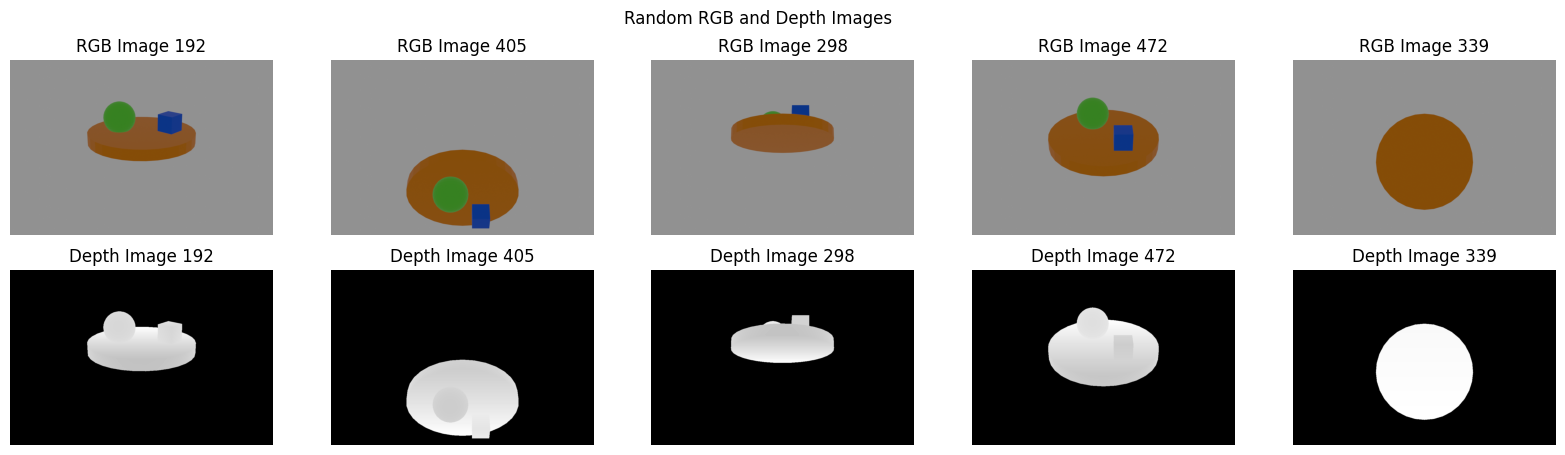

In [25]:
# show random dataset rgb images and depth images in one figure
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    idx = np.random.randint(frames_count)
    axs[0, i].imshow(frame_color_imgs[idx])
    axs[0, i].set_title(f"RGB Image {idx}")
    axs[0, i].axis("off")
    axs[1, i].imshow(frame_depth_imgs[idx], cmap="gray")
    axs[1, i].set_title(f"Depth Image {idx}")
    axs[1, i].axis("off")
plt.suptitle("Random RGB and Depth Images")
plt.show()


### Occupancy Dual Contouring

In [ ]:
import torch
import trimesh

volume_origin = torch.tensor(tsdf_obj.volume_origin, device="cuda:0")
tsdf_tensor = torch.tensor(tsdf_obj.get_tsdf()[0], device="cuda:0")
voxel_size = tsdf_obj.voxel_size


def implicit_function(xyz):
    """
    Implicit function for the TSDF volume. Performs trilinear interpolation to get the value at the given point.
    """
    # world space to voxel grid space
    relative_xyz = (xyz - volume_origin) / voxel_size

    device = relative_xyz.device
    min_bound = torch.tensor([0, 0, 0], dtype=torch.float64, device=device)
    max_bound = torch.tensor([tsdf_tensor.shape[0] - 1, 
                              tsdf_tensor.shape[1] - 1, 
                              tsdf_tensor.shape[2] - 1], dtype=torch.float64, device=device)
    relative_xyz = torch.clamp(relative_xyz, min=min_bound, max=max_bound)
    

    interpolated_values = []
    
    # interpolation for each point in xyz
    for i in range(xyz.shape[0]):
        xyz_point = relative_xyz[i]
        lower_indices = torch.floor(xyz_point).long()
        fractional_part = xyz_point - lower_indices.float()

        # neighbors - 8 surrounding points for trilinear interpolation
        x0, y0, z0 = lower_indices
        x1, y1, z1 = x0 + 1, y0 + 1, z0 + 1

        # Fetch the values at the 8 surrounding points 
        values = []
        for j, k, l in [(x0, y0, z0), (x0, y0, z1), (x0, y1, z0), (x0, y1, z1),
                         (x1, y0, z0), (x1, y0, z1), (x1, y1, z0), (x1, y1, z1)]:
            if 0 <= j < tsdf_tensor.shape[0] and 0 <= k < tsdf_tensor.shape[1] and 0 <= l < tsdf_tensor.shape[2]:
                values.append(tsdf_tensor[j, k, l])
            else:
                values.append(torch.tensor(0.0, dtype=torch.float64)) 
                
        c000, c001, c010, c011, c100, c101, c110, c111 = values
        c00 = c000 * (1 - fractional_part[0]) + c100 * fractional_part[0]
        c01 = c001 * (1 - fractional_part[0]) + c101 * fractional_part[0]
        c10 = c010 * (1 - fractional_part[0]) + c110 * fractional_part[0]
        c11 = c011 * (1 - fractional_part[0]) + c111 * fractional_part[0]
        c0 = c00 * (1 - fractional_part[1]) + c10 * fractional_part[1]
        c1 = c01 * (1 - fractional_part[1]) + c11 * fractional_part[1]
        interpolated_value = c0 * (1 - fractional_part[2]) + c1 * fractional_part[2]
        
        interpolated_values.append(interpolated_value)
    
    return torch.stack(interpolated_values)


from occupancy_dual_contouring import occupancy_dual_contouring
odc = occupancy_dual_contouring("cuda:0")
vertices, triangles = odc.extract_mesh(implicit_function, min_coord=tsdf_obj.volume_bounds[:,0].flatten(), max_coord=tsdf_obj.volume_bounds[:,1].flatten(), num_grid=64)
mesh = trimesh.Trimesh(vertices.cpu().numpy(), triangles.cpu().numpy())
